# Import needed modules

In [1]:
# import system libs
import os
import time
import shutil
import pathlib
import itertools

# import data handling tools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

modules loaded


In [2]:
# Import necessary libraries
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Function to generate file paths with labels
def define_paths(base_dir):
    filepaths = []
    labels = []

    # Get all fold directories
    folds = [f'fold_{i}' for i in range(3)]
    for fold in folds:
        foldpath = os.path.join(base_dir, fold)
        for label in ['all', 'hem']:
            labelpath = os.path.join(foldpath, label)
            for file_ in os.listdir(labelpath):
                filepath = os.path.join(labelpath, file_)
                filepaths.append(filepath)
                labels.append(label)
    
    return filepaths, labels

# Concatenate data paths with labels into one dataframe
def define_df(files, classes):
    Fseries = pd.Series(files, name='filepaths')
    Lseries = pd.Series(classes, name='labels')
    return pd.concat([Fseries, Lseries], axis=1)

# Function to create dataframe for train, validation, and test data
def create_df(base_dir):
    # Get file paths and labels
    files, classes = define_paths(base_dir)
    df = define_df(files, classes)
    
    # Print the dataframe to check
    print("Combined Dataframe Head:")
    print(df.head())
    
    # Remove classes with fewer than 2 samples
    class_counts = df['labels'].value_counts()
    to_remove = class_counts[class_counts < 2].index
    df = df[~df['labels'].isin(to_remove)]
    
    # Print the class distribution
    print("Class Distribution after removing classes with fewer than 2 samples:")
    print(df['labels'].value_counts())
    
    strat = df['labels']
    train_df, dummy_df = train_test_split(df, train_size=0.7, shuffle=True, random_state=123, stratify=strat)
    
    strat = dummy_df['labels']
    valid_df, test_df = train_test_split(dummy_df, train_size=0.5, shuffle=True, random_state=123, stratify=strat)
    
    # Print the size of the splits
    print(f"Training set size: {len(train_df)}")
    print(f"Validation set size: {len(valid_df)}")
    print(f"Test set size: {len(test_df)}")
    
    return train_df, valid_df, test_df

# Function to balance the dataset
def balance_dataset(df):
    # Separate majority and minority classes
    df_majority = df[df['labels'] == 'all']
    df_minority = df[df['labels'] == 'hem']
    
    # Downsample majority class
    df_majority_downsampled = resample(df_majority, 
                                       replace=False,    # sample without replacement
                                       n_samples=len(df_minority),  # to match minority class
                                       random_state=123) # reproducible results
    
    # Combine minority class with downsampled majority class
    df_balanced = pd.concat([df_majority_downsampled, df_minority])
    
    # Shuffle the dataset
    df_balanced = df_balanced.sample(frac=1, random_state=123).reset_index(drop=True)
    
    return df_balanced

# Function to create data generators
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
import numpy as np

def create_model_data(train_df=None, valid_df=None, test_df=None, batch_size=None, mode='dataset'):
    img_size = (299, 299)
    color = 'rgb'
    
    if mode == 'dataset':
        # Custom test batch size
        ts_length = len(test_df)
        test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length % n == 0 and ts_length / n <= 80]))

        # Custom function for data augmentation, it just takes the image and returns it again.
        def scalar(img):
            return img

        tr_gen = ImageDataGenerator(preprocessing_function=scalar, horizontal_flip=True)
        ts_gen = ImageDataGenerator(preprocessing_function=scalar)
        
        train_gen = tr_gen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical', color_mode=color, shuffle=True, batch_size=batch_size)
        valid_gen = ts_gen.flow_from_dataframe(valid_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical', color_mode=color, shuffle=True, batch_size=batch_size)
        test_gen = ts_gen.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical', color_mode=color, shuffle=False, batch_size=test_batch_size)
        
        return train_gen, valid_gen, test_gen
    
    elif mode == 'single_image':
        # Function for single image preprocessing
        def scalar(img):
            return img
        
        tr_gen = ImageDataGenerator(preprocessing_function=scalar)
        
        return tr_gen


# Example function for single image preprocessing
def preprocess_single_image(img_path, tr_gen):
    img = load_img(img_path, target_size=(299, 299))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    
    # Apply preprocessing function
    img_array = tr_gen.standardize(img_array)
    
    return img_array


# Load data
data_dir = '/kaggle/input/leukemia-classification/C-NMC_Leukemia/training_data'  # Replace with your actual data directory
train_df, valid_df, test_df = create_df(data_dir)

# Balance the training dataset
balanced_train_df = balance_dataset(train_df)

# Print number of images per class in balanced training dataset
class_counts = balanced_train_df['labels'].value_counts()
for label, count in class_counts.items():
    print(f"Number of images in class '{label}' after balancing: {count}")

# Create the data generators
batch_size = 32  # Define your batch size
train_gen, valid_gen, test_gen = create_model_data(balanced_train_df, valid_df, test_df, batch_size)

# Print total number of images in the balanced training generator
print(f"Total number of images in the balanced training generator: {train_gen.n}")


Combined Dataframe Head:
                                           filepaths labels
0  /kaggle/input/leukemia-classification/C-NMC_Le...    all
1  /kaggle/input/leukemia-classification/C-NMC_Le...    all
2  /kaggle/input/leukemia-classification/C-NMC_Le...    all
3  /kaggle/input/leukemia-classification/C-NMC_Le...    all
4  /kaggle/input/leukemia-classification/C-NMC_Le...    all
Class Distribution after removing classes with fewer than 2 samples:
all    7272
hem    3389
Name: labels, dtype: int64
Training set size: 7462
Validation set size: 1599
Test set size: 1600
Number of images in class 'hem' after balancing: 2372
Number of images in class 'all' after balancing: 2372
Found 4744 validated image filenames belonging to 2 classes.
Found 1599 validated image filenames belonging to 2 classes.
Found 1600 validated image filenames belonging to 2 classes.
Total number of images in the balanced training generator: 4744


# Create needed functions

In [3]:
def show_images(gen):
    '''
    This function take the data generator and show sample of the images
    '''

    # return classes , images to be displayed
    g_dict = gen.class_indices        # defines dictionary {'class': index}
    classes = list(g_dict.keys())     # defines list of dictionary's kays (classes), classes names : string
    images, labels = next(gen)        # get a batch size samples from the generator

    # calculate number of displayed samples
    length = len(labels)        # length of batch size
    sample = min(length, 25)    # check if sample less than 25 images

    plt.figure(figsize= (20, 20))

    for i in range(sample):
        plt.subplot(5, 5, i + 1)
        image = images[i] / 255       # scales data to range (0 - 255)
        plt.imshow(image)
        index = np.argmax(labels[i])  # get image index
        class_name = classes[index]   # get class of image
        plt.title(class_name, color= 'blue', fontsize= 12)
        plt.axis('off')
    plt.show()

#### **Function to plot value counts for a column in a dataframe**

In [4]:
def plot_label_count(df, plot_title):
    '''
    This function take df and plot labels value counts
    '''

    # Define needed variables
    vcounts = df['labels'].value_counts()
    labels = vcounts.keys().tolist()
    values = vcounts.tolist()
    lcount = len(labels)

    if lcount > 55:
        print('The number of labels is > 55, no plot will be produced')

    else:
        plot_labels(lcount, labels, values, plot_title)

def plot_labels(lcount, labels, values, plot_title):
    width = lcount * 4
    width = np.min([width, 20])

    plt.figure(figsize= (width, 5))

    form = {'family': 'serif', 'color': 'blue', 'size': 25}
    sns.barplot(labels, values)
    plt.title(f'Images per Label in {plot_title} data', fontsize= 24, color= 'blue')
    plt.xticks(rotation= 90, fontsize= 18)
    plt.yticks(fontsize= 18)
    plt.xlabel('CLASS', fontdict= form)
    yaxis_label = 'IMAGE COUNT'
    plt.ylabel(yaxis_label, fontdict= form)

    rotation = 'vertical' if lcount >= 8 else 'horizontal'
    for i in range(lcount):
        plt.text(i, values[i] / 2, str(values[i]), fontsize= 12,
                rotation= rotation, color= 'yellow', ha= 'center')

    plt.show()

#### **Callbacks** 
<br> 
Callbacks : Helpful functions to help optimize model training  <br> 
Examples: stop model training after specfic time, stop training if no improve in accuracy and so on.

In [5]:
class MyCallback(keras.callbacks.Callback):
    def __init__(self, model, patience, stop_patience, threshold, factor, batches, epochs, ask_epoch):
        super(MyCallback, self).__init__()
        self.model = model
        self.patience = patience # specifies how many epochs without improvement before learning rate is adjusted
        self.stop_patience = stop_patience # specifies how many times to adjust lr without improvement to stop training
        self.threshold = threshold # specifies training accuracy threshold when lr will be adjusted based on validation loss
        self.factor = factor # factor by which to reduce the learning rate
        self.batches = batches # number of training batch to run per epoch
        self.epochs = epochs
        self.ask_epoch = ask_epoch
        self.ask_epoch_initial = ask_epoch # save this value to restore if restarting training

        # callback variables
        self.count = 0 # how many times lr has been reduced without improvement
        self.stop_count = 0
        self.best_epoch = 1   # epoch with the lowest loss
        self.initial_lr = float(tf.keras.backend.get_value(model.optimizer.lr)) # get the initial learning rate and save it
        self.highest_tracc = 0.0 # set highest training accuracy to 0 initially
        self.lowest_vloss = np.inf # set lowest validation loss to infinity initially
        self.best_weights = self.model.get_weights() # set best weights to model's initial weights
        self.initial_weights = self.model.get_weights()   # save initial weights if they have to get restored

    # Define a function that will run when train begins
    def on_train_begin(self, logs= None):
        msg = 'Do you want model asks you to halt the training [y/n] ?'
        print(msg)
        ans = input('')
        if ans in ['Y', 'y']:
            self.ask_permission = 1
        elif ans in ['N', 'n']:
            self.ask_permission = 0

        msg = '{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^10s}{8:10s}{9:^8s}'.format('Epoch', 'Loss', 'Accuracy', 'V_loss', 'V_acc', 'LR', 'Next LR', 'Monitor','% Improv', 'Duration')
        print(msg)
        self.start_time = time.time()


    def on_train_end(self, logs= None):
        stop_time = time.time()
        tr_duration = stop_time - self.start_time
        hours = tr_duration // 3600
        minutes = (tr_duration - (hours * 3600)) // 60
        seconds = tr_duration - ((hours * 3600) + (minutes * 60))

        msg = f'training elapsed time was {str(hours)} hours, {minutes:4.1f} minutes, {seconds:4.2f} seconds)'
        print(msg)

        # set the weights of the model to the best weights
        self.model.set_weights(self.best_weights)


    def on_train_batch_end(self, batch, logs= None):
        # get batch accuracy and loss
        acc = logs.get('accuracy') * 100
        loss = logs.get('loss')

        # prints over on the same line to show running batch count
        msg = '{0:20s}processing batch {1:} of {2:5s}-   accuracy=  {3:5.3f}   -   loss: {4:8.5f}'.format(' ', str(batch), str(self.batches), acc, loss)
        print(msg, '\r', end= '')


    def on_epoch_begin(self, epoch, logs= None):
        self.ep_start = time.time()


    # Define method runs on the end of each epoch
    def on_epoch_end(self, epoch, logs= None):
        ep_end = time.time()
        duration = ep_end - self.ep_start

        lr = float(tf.keras.backend.get_value(self.model.optimizer.lr)) # get the current learning rate
        current_lr = lr
        acc = logs.get('accuracy')  # get training accuracy
        v_acc = logs.get('val_accuracy')  # get validation accuracy
        loss = logs.get('loss')  # get training loss for this epoch
        v_loss = logs.get('val_loss')  # get the validation loss for this epoch

        if acc < self.threshold: # if training accuracy is below threshold adjust lr based on training accuracy
            monitor = 'accuracy'
            if epoch == 0:
                pimprov = 0.0
            else:
                pimprov = (acc - self.highest_tracc ) * 100 / self.highest_tracc # define improvement of model progres

            if acc > self.highest_tracc: # training accuracy improved in the epoch
                self.highest_tracc = acc # set new highest training accuracy
                self.best_weights = self.model.get_weights() # training accuracy improved so save the weights
                self.count = 0 # set count to 0 since training accuracy improved
                self.stop_count = 0 # set stop counter to 0
                if v_loss < self.lowest_vloss:
                    self.lowest_vloss = v_loss
                self.best_epoch = epoch + 1  # set the value of best epoch for this epoch

            else:
                # training accuracy did not improve check if this has happened for patience number of epochs
                # if so adjust learning rate
                if self.count >= self.patience - 1: # lr should be adjusted
                    lr = lr * self.factor # adjust the learning by factor
                    tf.keras.backend.set_value(self.model.optimizer.lr, lr) # set the learning rate in the optimizer
                    self.count = 0 # reset the count to 0
                    self.stop_count = self.stop_count + 1 # count the number of consecutive lr adjustments
                    self.count = 0 # reset counter
                    if v_loss < self.lowest_vloss:
                        self.lowest_vloss = v_loss
                else:
                    self.count = self.count + 1 # increment patience counter

        else: # training accuracy is above threshold so adjust learning rate based on validation loss
            monitor = 'val_loss'
            if epoch == 0:
                pimprov = 0.0

            else:
                pimprov = (self.lowest_vloss - v_loss ) * 100 / self.lowest_vloss

            if v_loss < self.lowest_vloss: # check if the validation loss improved
                self.lowest_vloss = v_loss # replace lowest validation loss with new validation loss
                self.best_weights = self.model.get_weights() # validation loss improved so save the weights
                self.count = 0 # reset count since validation loss improved
                self.stop_count = 0
                self.best_epoch = epoch + 1 # set the value of the best epoch to this epoch

            else: # validation loss did not improve
                if self.count >= self.patience - 1: # need to adjust lr
                    lr = lr * self.factor # adjust the learning rate
                    self.stop_count = self.stop_count + 1 # increment stop counter because lr was adjusted
                    self.count = 0 # reset counter
                    tf.keras.backend.set_value(self.model.optimizer.lr, lr) # set the learning rate in the optimizer

                else:
                    self.count = self.count + 1 # increment the patience counter

                if acc > self.highest_tracc:
                    self.highest_tracc = acc

        msg = f'{str(epoch + 1):^3s}/{str(self.epochs):4s} {loss:^9.3f}{acc * 100:^9.3f}{v_loss:^9.5f}{v_acc * 100:^9.3f}{current_lr:^9.5f}{lr:^9.5f}{monitor:^11s}{pimprov:^10.2f}{duration:^8.2f}'
        print(msg)

        if self.stop_count > self.stop_patience - 1: # check if learning rate has been adjusted stop_count times with no improvement
            msg = f' training has been halted at epoch {epoch + 1} after {self.stop_patience} adjustments of learning rate with no improvement'
            print(msg)
            self.model.stop_training = True # stop training

        else:
            if self.ask_epoch != None and self.ask_permission != 0:
                if epoch + 1 >= self.ask_epoch:
                    msg = 'enter H to halt training or an integer for number of epochs to run then ask again'
                    print(msg)

                    ans = input('')
                    if ans == 'H' or ans == 'h':
                        msg = f'training has been halted at epoch {epoch + 1} due to user input'
                        print(msg)
                        self.model.stop_training = True # stop training

                    else:
                        try:
                            ans = int(ans)
                            self.ask_epoch += ans
                            msg = f' training will continue until epoch {str(self.ask_epoch)}'
                            print(msg)
                            msg = '{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^10s}{8:10s}{9:^8s}'.format('Epoch', 'Loss', 'Accuracy', 'V_loss', 'V_acc', 'LR', 'Next LR', 'Monitor', '% Improv', 'Duration')
                            print(msg)

                        except Exception:
                            print('Invalid')

#### **Function to plot history of training**

In [6]:
def plot_training(hist):
    '''
    This function take training model and plot history of accuracy and losses with the best epoch in both of them.
    '''

    # Define needed variables
    tr_acc = hist.history['accuracy']
    tr_loss = hist.history['loss']
    val_acc = hist.history['val_accuracy']
    val_loss = hist.history['val_loss']
    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]
    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]
    Epochs = [i+1 for i in range(len(tr_acc))]
    loss_label = f'best epoch= {str(index_loss + 1)}'
    acc_label = f'best epoch= {str(index_acc + 1)}'

    # Plot training history
    plt.figure(figsize= (20, 8))
    plt.style.use('fivethirtyeight')

    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
    plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
    plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout
    plt.show()


#### **Function to create Confusion Matrix**

In [7]:
def plot_confusion_matrix(cm, classes, normalize= False, title= 'Confusion Matrix', cmap= plt.cm.Blues):
	'''
	This function plot confusion matrix method from sklearn package.
	'''

	plt.figure(figsize= (10, 10))
	plt.imshow(cm, interpolation= 'nearest', cmap= cmap)
	plt.title(title)
	plt.colorbar()

	tick_marks = np.arange(len(classes))
	plt.xticks(tick_marks, classes, rotation= 45)
	plt.yticks(tick_marks, classes)

	if normalize:
		cm = cm.astype('float') / cm.sum(axis= 1)[:, np.newaxis]
		print('Normalized Confusion Matrix')

	else:
		print('Confusion Matrix, Without Normalization')

	print(cm)

	thresh = cm.max() / 2.
	for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
		plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

	plt.tight_layout()
	plt.ylabel('True Label')
	plt.xlabel('Predicted Label')

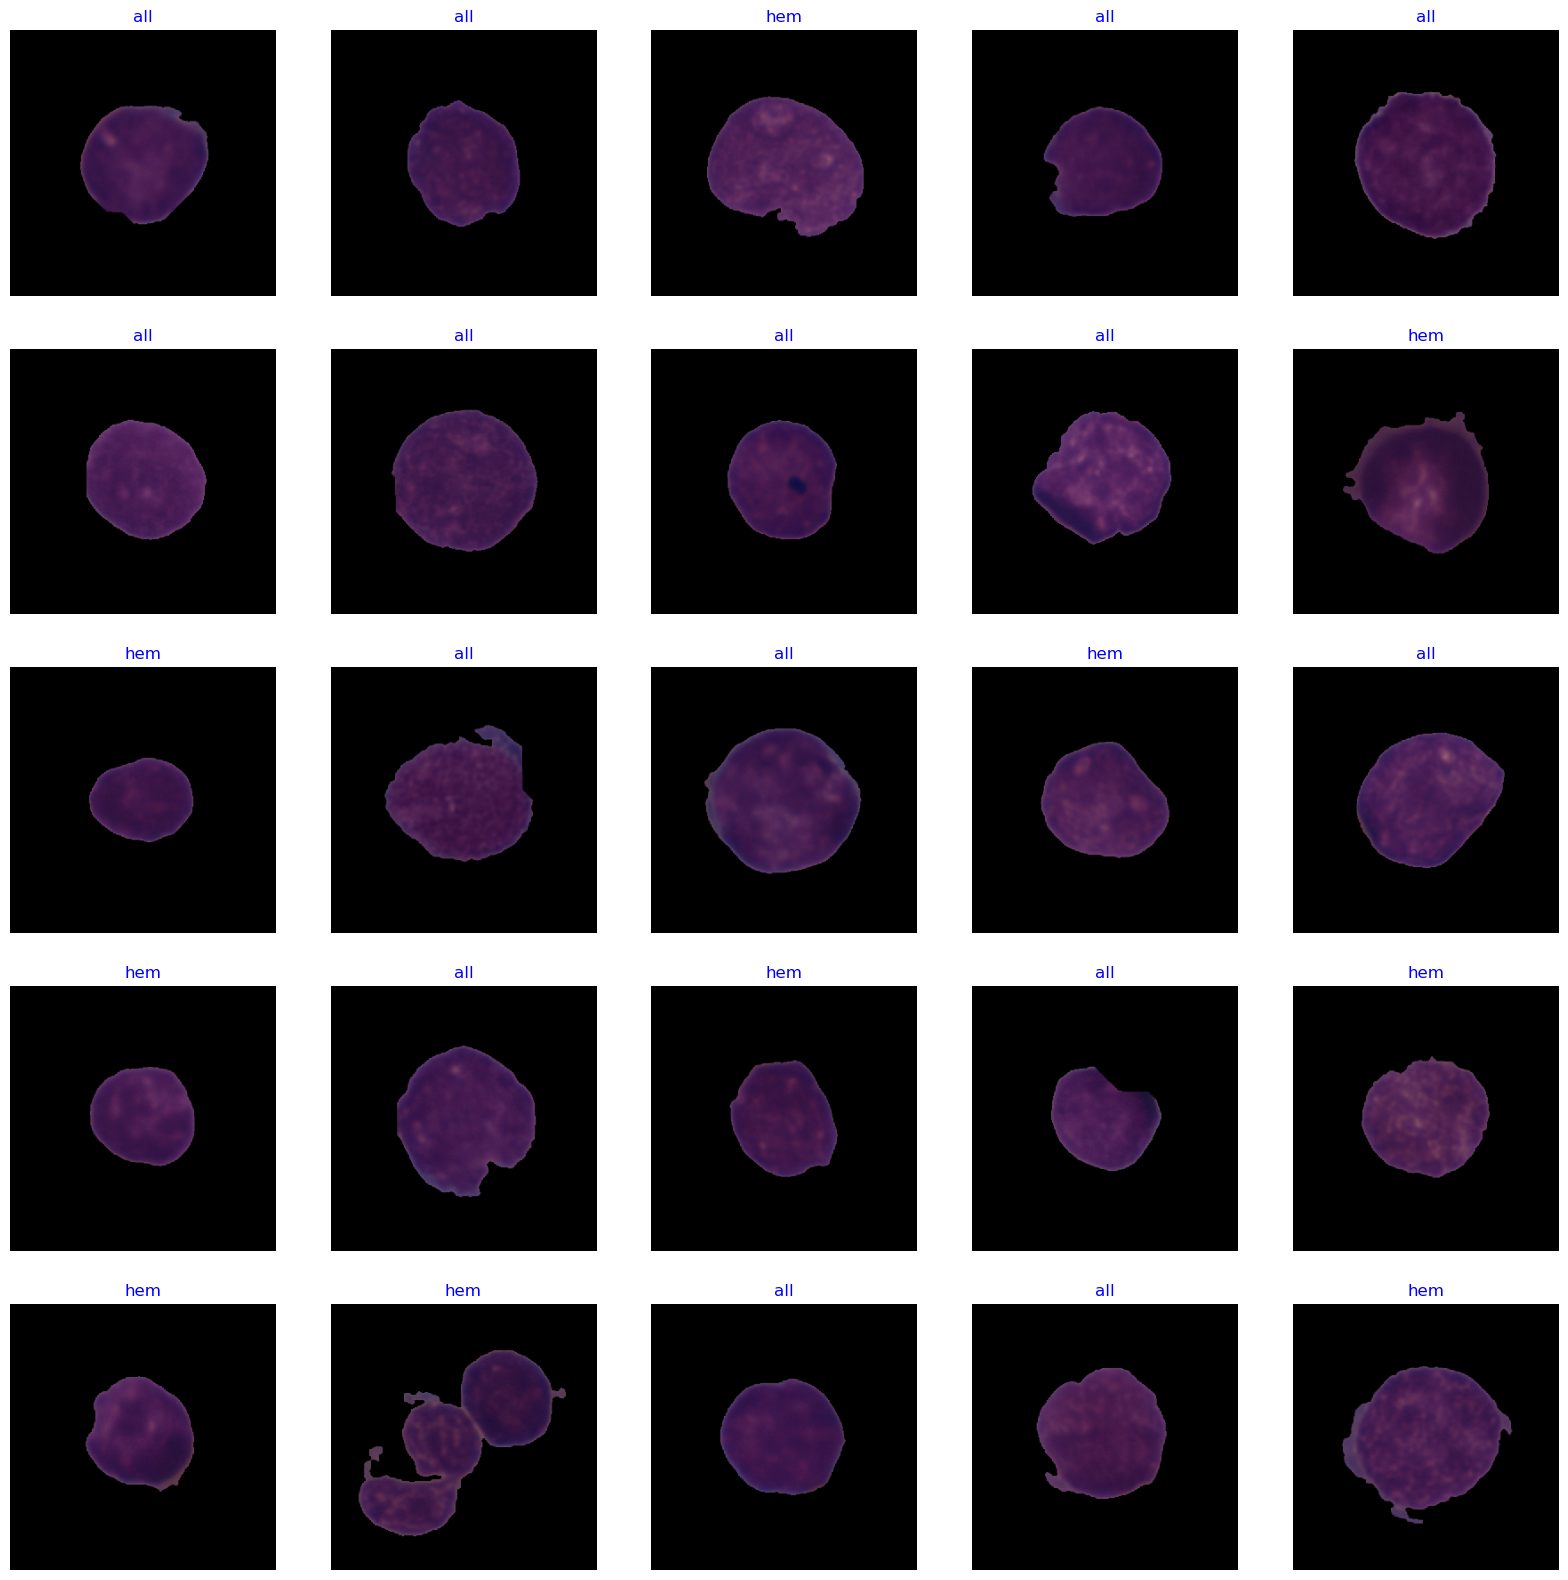

Total number of images in the training generator: 4744
Class indices: {'all': 0, 'hem': 1}
Number of images in class 'hem': 2372
Number of images in class 'all': 2372


In [8]:
show_images(train_gen)
# Print total number of images in the train generator
print(f"Total number of images in the training generator: {train_gen.n}")

# Print class indices
print("Class indices:", train_gen.class_indices)

# Print number of images per class
class_counts = pd.Series(train_gen.classes).value_counts()
for label_index, count in class_counts.items():
    label_name = list(train_gen.class_indices.keys())[list(train_gen.class_indices.values()).index(label_index)]
    print(f"Number of images in class '{label_name}': {count}")


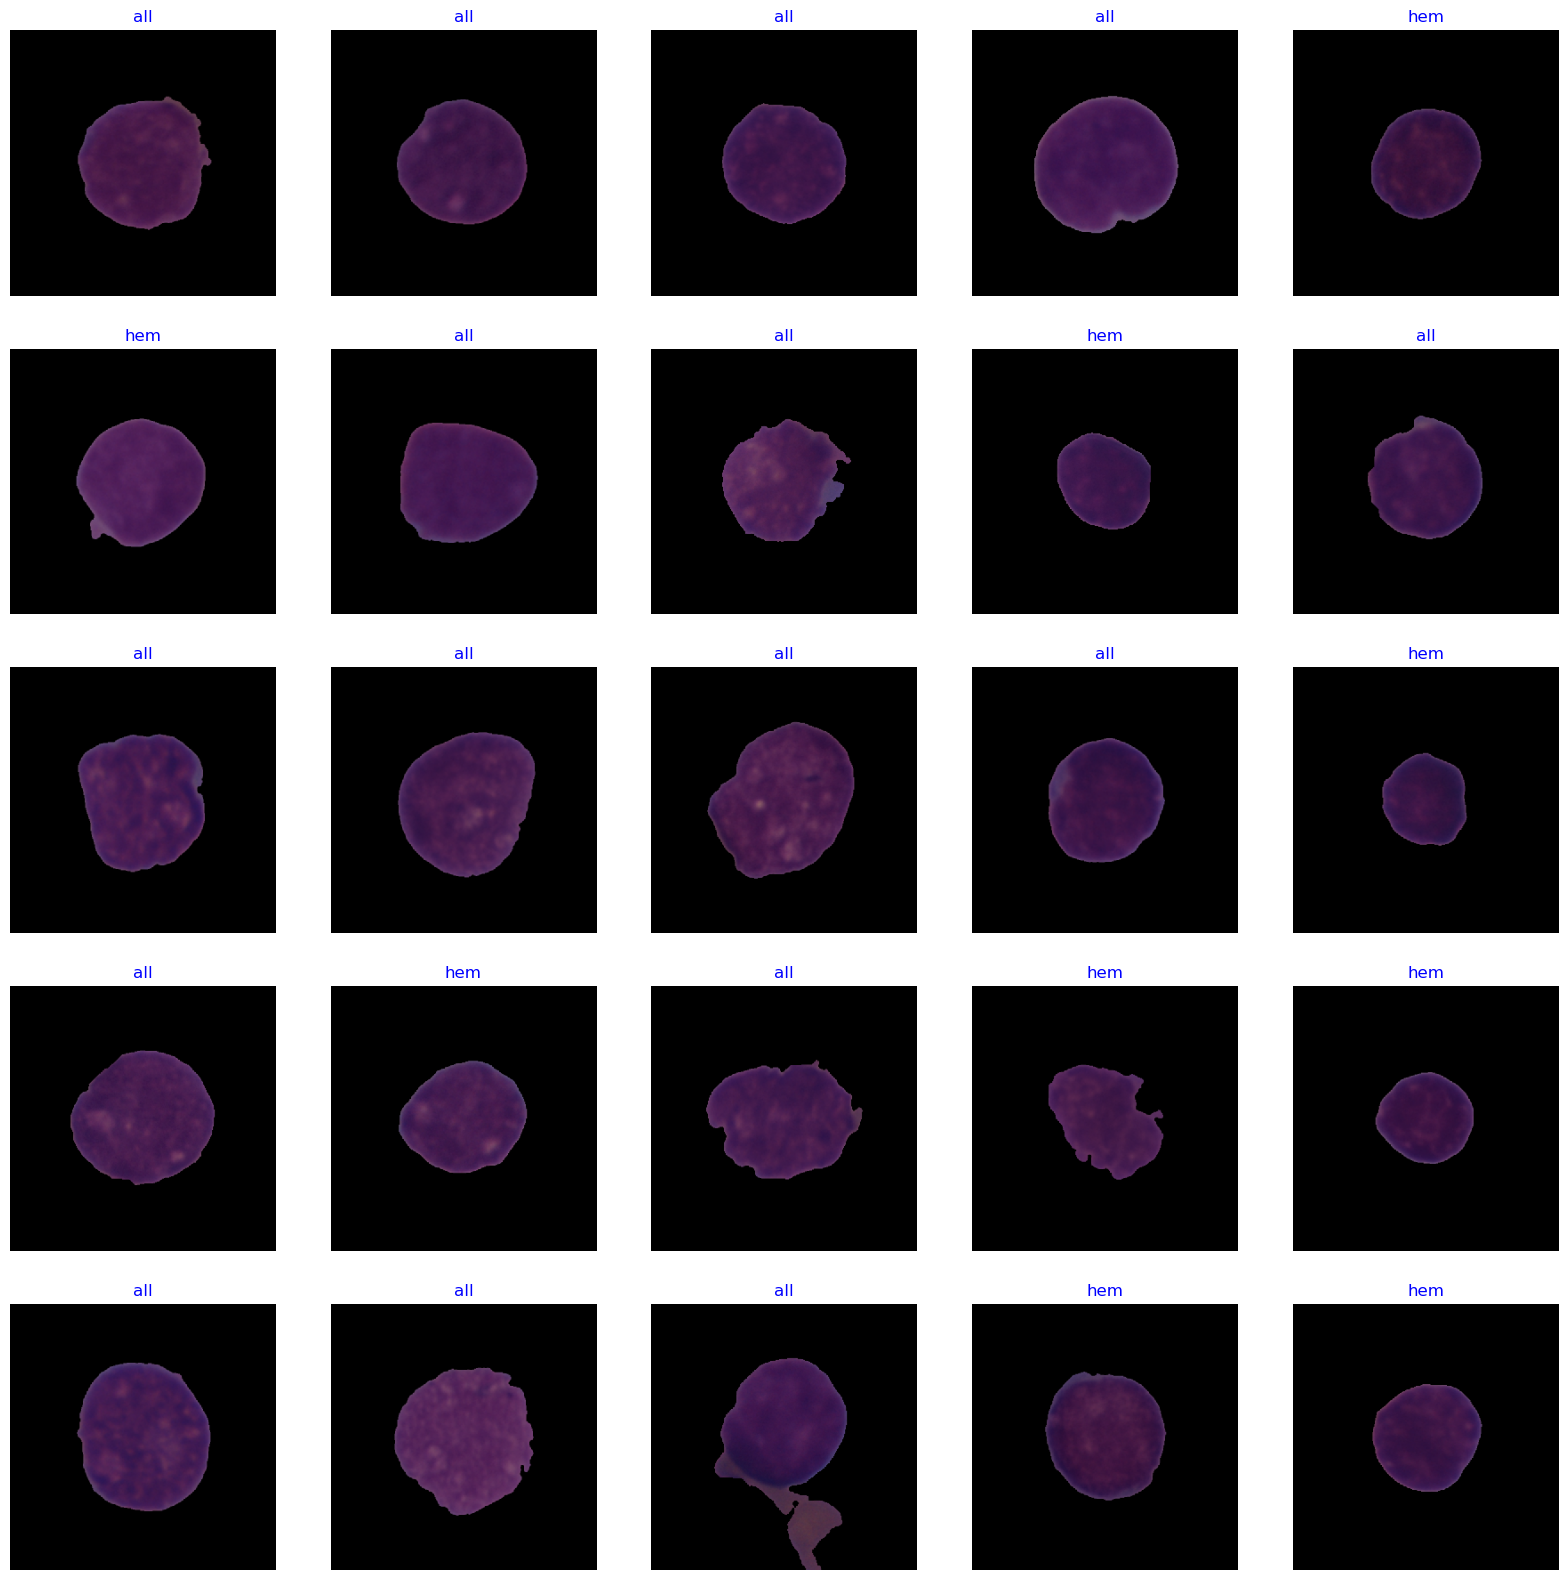

Total number of images in the training generator: 1599
Class indices: {'all': 0, 'hem': 1}
Number of images in class 'all': 1091
Number of images in class 'hem': 508


In [9]:
show_images(valid_gen)
# Print total number of images in the train generator
print(f"Total number of images in the training generator: {valid_gen.n}")

# Print class indices
print("Class indices:", valid_gen.class_indices)

# Print number of images per class
class_counts = pd.Series(valid_gen.classes).value_counts()
for label_index, count in class_counts.items():
    label_name = list(valid_gen.class_indices.keys())[list(valid_gen.class_indices.values()).index(label_index)]
    print(f"Number of images in class '{label_name}': {count}")


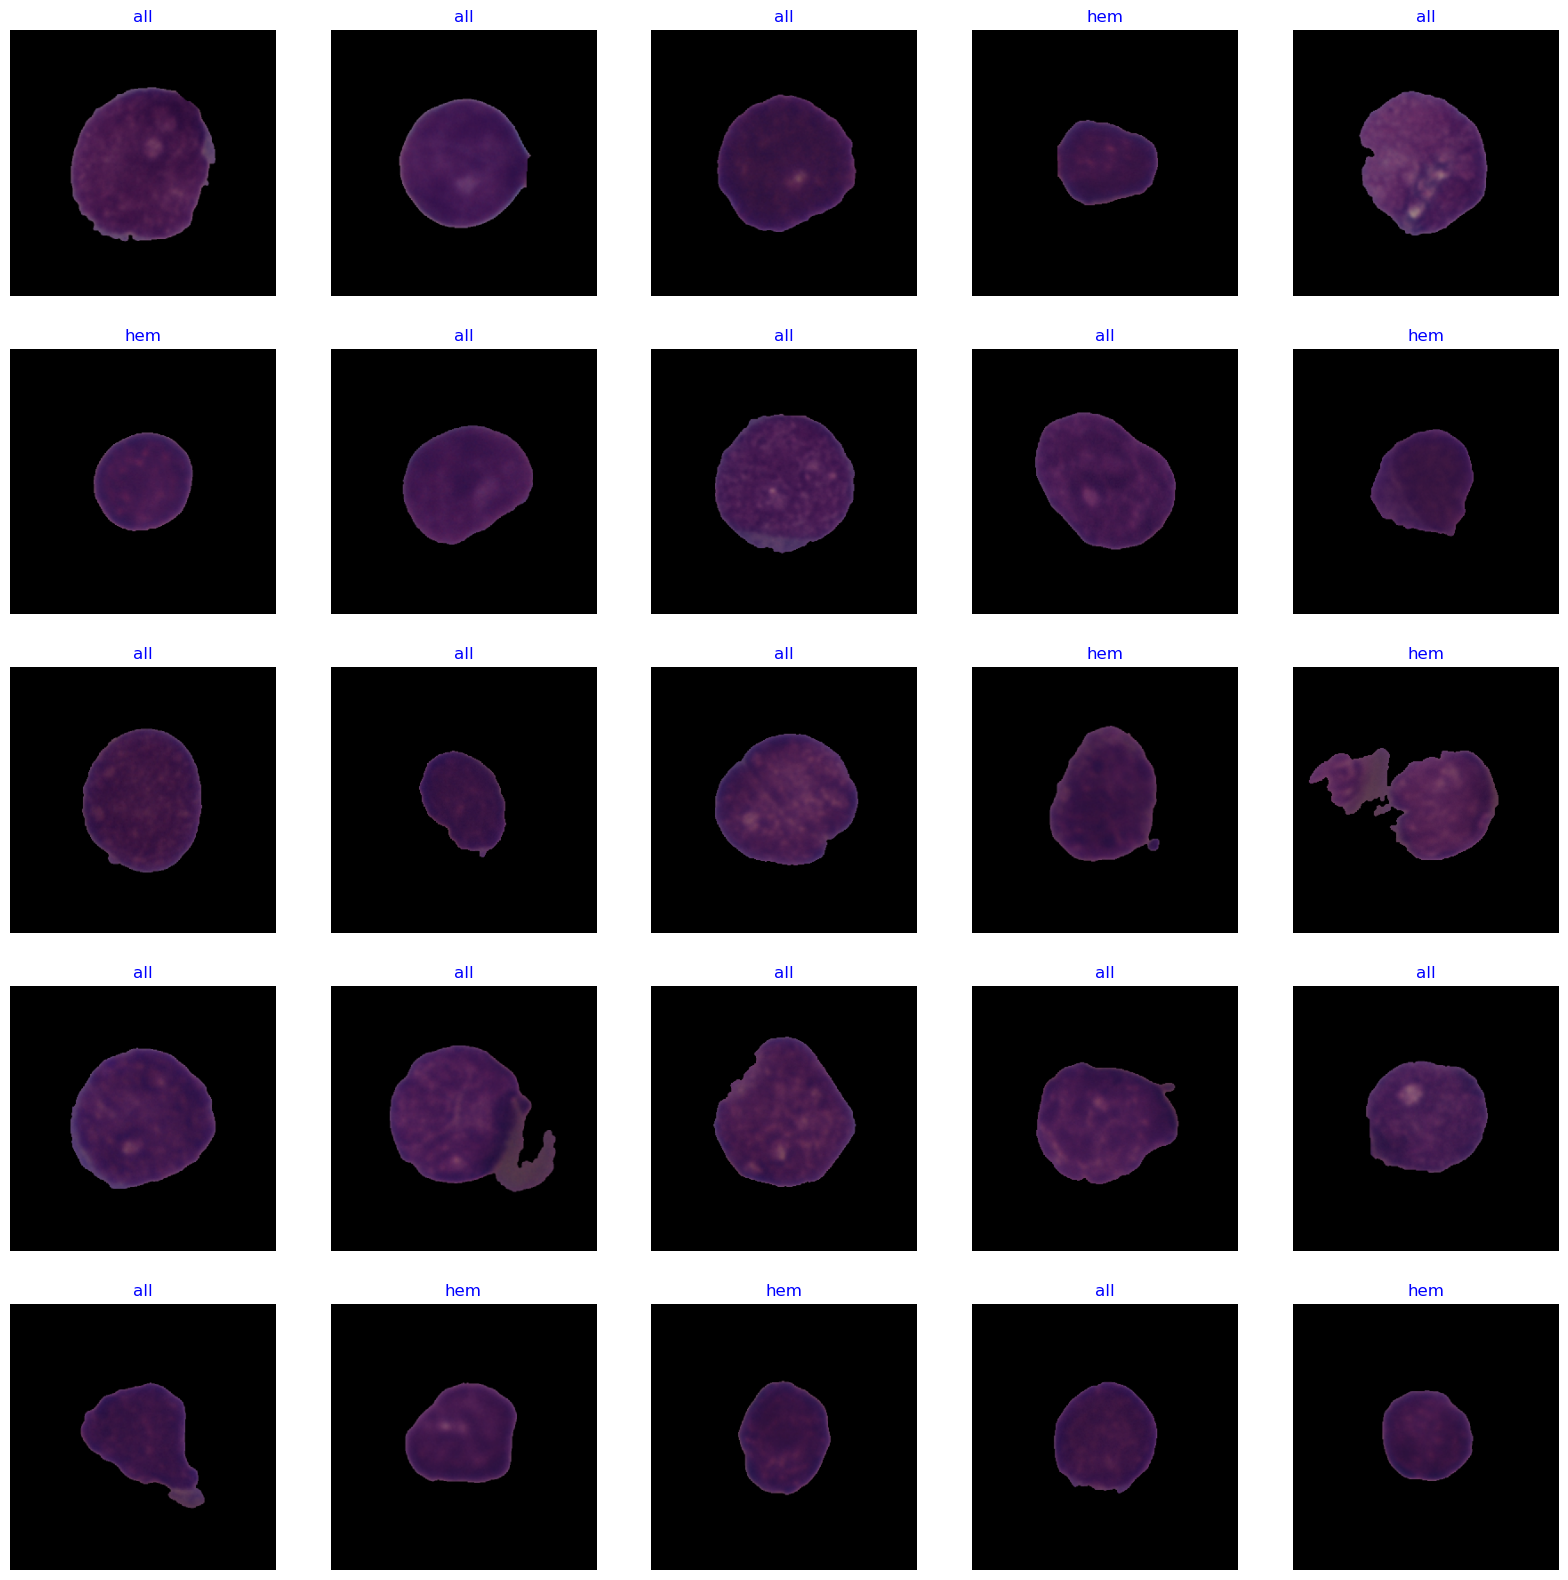

Total number of images in the training generator: 1600
Class indices: {'all': 0, 'hem': 1}
Number of images in class 'all': 1091
Number of images in class 'hem': 509


In [10]:
show_images(test_gen)
# Print total number of images in the train generator
print(f"Total number of images in the training generator: {test_gen.n}")

# Print class indices
print("Class indices:", test_gen.class_indices)

# Print number of images per class
class_counts = pd.Series(test_gen.classes).value_counts()
for label_index, count in class_counts.items():
    label_name = list(test_gen.class_indices.keys())[list(test_gen.class_indices.values()).index(label_index)]
    print(f"Number of images in class '{label_name}': {count}")


#### **Generic Model Creation**

In [11]:
# import tensorflow as tf
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
# from tensorflow.keras.applications import Xception
# from tensorflow.keras.optimizers import Adamax
# from tensorflow.keras import regularizers

# # Create Model Structure
# img_size = (299, 299)  # Adjusted to match Xception's input size
# channels = 3
# img_shape = (img_size[0], img_size[1], channels)
# class_count = len(list(train_gen.class_indices.keys()))  # Number of classes in dense layer

# # Create pre-trained model (Xception)
# base_model = Xception(include_top=False, weights='imagenet', input_shape=img_shape, pooling='max')

# model = Sequential([
#     base_model,
#     BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001),
#     Dense(256, kernel_regularizer=regularizers.l2(l=0.016), 
#           activity_regularizer=regularizers.l1(0.006),
#           bias_regularizer=regularizers.l1(0.006), activation='relu'),
#     Dropout(rate=0.45, seed=123),
#     Dense(class_count, activation='softmax')
# ])

# # Compile the model
# model.compile(Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# # Print model summary
# model.summary()


In [12]:
# import tensorflow as tf
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
# from tensorflow.keras.applications import InceptionResNetV2
# from tensorflow.keras.optimizers import Adamax
# from tensorflow.keras import regularizers

# # Create Model Structure
# img_size = (299, 299)  # Adjusted to match InceptionResNetV2's input size
# channels = 3
# img_shape = (img_size[0], img_size[1], channels)
# class_count = len(list(train_gen.class_indices.keys()))  # Number of classes in dense layer

# # Create pre-trained model (InceptionResNetV2)
# base_model = InceptionResNetV2(include_top=False, weights='imagenet', input_shape=img_shape, pooling='max')

# model = Sequential([
#     base_model,
#     BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001),
#     Dense(256, kernel_regularizer=regularizers.l2(l=0.016), 
#           activity_regularizer=regularizers.l1(0.006),
#           bias_regularizer=regularizers.l1(0.006), activation='relu'),
#     Dropout(rate=0.45, seed=123),
#     Dense(class_count, activation='softmax')
# ])

# # Compile the model
# model.compile(Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# # Print model summary
# model.summary()


In [13]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras import regularizers

# Create Model Structure
img_size = (299, 299)  # Adjusted to match InceptionV3's input size
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys()))  # Number of classes in dense layer

# Create pre-trained model (InceptionV3)
base_model = InceptionV3(include_top=False, weights='imagenet', input_shape=img_shape, pooling='max')

model = Sequential([
    base_model,
    BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001),
    Dense(256, kernel_regularizer=regularizers.l2(l=0.016), 
          activity_regularizer=regularizers.l1(0.006),
          bias_regularizer=regularizers.l1(0.006), activation='relu'),
    Dropout(rate=0.45, seed=123),
    Dense(class_count, activation='softmax')
])

# Compile the model
model.compile(Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()


#### **Set Callback Parameters**

In [14]:
batch_size = 32   # set batch size for training
epochs = 15   # number of all epochs in training
patience = 1   #number of epochs to wait to adjust lr if monitored value does not improve
stop_patience = 3   # number of epochs to wait before stopping training if monitored value does not improve
threshold = 0.9   # if train accuracy is < threshold adjust monitor accuracy, else monitor validation loss
factor = 0.5   # factor to reduce lr by
ask_epoch = 5   # number of epochs to run before asking if you want to halt training
batches = int(np.ceil(len(train_gen.labels) / batch_size))    # number of training batch to run per epoch

callbacks = [MyCallback(model= model, patience= patience, stop_patience= stop_patience, threshold= threshold,
            factor= factor, batches= batches, epochs= epochs, ask_epoch= ask_epoch )]

#### **Train model**

In [15]:
history = model.fit(x= train_gen, epochs= epochs, verbose= 0, callbacks= callbacks,
                    validation_data= valid_gen, validation_steps= None, shuffle= False)

#### **Display model performance**

In [16]:
plot_training(history)

# **Evaluate model**

In [17]:
ts_length = len(test_df)
test_batch_size = test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

# **Get Predictions**

In [18]:
preds = model.predict_generator(test_gen)
y_pred = np.argmax(preds, axis=1)
print(y_pred)

#### **Confusion Matrics and Classification Report**

In [19]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)
plot_confusion_matrix(cm= cm, classes= classes, title = 'Confusion Matrix')

# Classification report
print(classification_report(test_gen.classes, y_pred, target_names= classes))

In [20]:
# Load and preprocess a single image
img_path = '/kaggle/input/leukemia-classification/C-NMC_Leukemia/training_data/fold_2/all/UID_13_14_2_all.bmp'  # Replace with your image path
img = load_img(img_path, target_size=(299, 299))  # Same size as used in training
img_array = img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Model expects a batch dimension

# Use the same preprocessing function as in training (for single image)
tr_gen = create_model_data(mode='single_image')
img_array = tr_gen.standardize(img_array)

# Make prediction (assuming `model` is loaded and ready)
predictions = model.predict(img_array)

# Interpret the prediction
predicted_class = np.argmax(predictions, axis=-1)
predicted_class_label = list(train_gen.class_indices.keys())[predicted_class[0]]  # Assuming `train_gen` is defined in 'dataset' mode

# Print the prediction and probabilities
print(f'Predicted class: {predicted_class_label}')
probabilities = predictions[0]
for i, prob in enumerate(probabilities):
    class_label = list(train_gen.class_indices.keys())[i]
    print(f'Probability of {class_label}: {prob:.4f}')

In [21]:
# Load and preprocess a single image
img_path = '/kaggle/input/leukemia-classification/C-NMC_Leukemia/training_data/fold_1/hem/UID_H10_100_2_hem.bmp'  # Replace with your image path
img = load_img(img_path, target_size=(299, 299))  # Same size as used in training
img_array = img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Model expects a batch dimension

# Use the same preprocessing function as in training (for single image)
tr_gen = create_model_data(mode='single_image')
img_array = tr_gen.standardize(img_array)

# Make prediction (assuming `model` is loaded and ready)
predictions = model.predict(img_array)

# Interpret the prediction
predicted_class = np.argmax(predictions, axis=-1)
predicted_class_label = list(train_gen.class_indices.keys())[predicted_class[0]]  # Assuming `train_gen` is defined in 'dataset' mode

# Print the prediction and probabilities
print(f'Predicted class: {predicted_class_label}')
probabilities = predictions[0]
for i, prob in enumerate(probabilities):
    class_label = list(train_gen.class_indices.keys())[i]
    print(f'Probability of {class_label}: {prob:.4f}')

#### **Save model**

In [22]:
model.save('InceptionV3.h5')

In [23]:
from IPython.display import FileLink

# Provide the path to your model file
file_path = 'InceptionV3.h5'
FileLink(file_path)
